In [1]:
import cv2, os
import shutil
from typing import List, Tuple
from collections import defaultdict
import json

import h5py
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter

In [2]:
# Quita la carretera y elementos distractores
def quitarElementosGrises(img_path, name):
    img = cv2.imread(img_path)

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(hsv, (0,0,0), (255,45,255))

    new_img = img.copy()
    new_img[np.where(mask)] = 255
    cv2.imwrite(os.path.join('./Saturacion/',name), new_img)
    
for i in range(0,22248):
    name = "escena_" + str(i) + '.png'
    quitarElementosGrises('./Imagenes/'+name,name)

KeyboardInterrupt: 

In [7]:
# Obtiene las coodenadas de los pixeles de la imagen que no son blancos
def obtenerCoordenadas(image_path):
    image = Image.open(image_path)
    width, height = image.size
    coordinates = []

    for x in range(width):
        for y in range(height):
            r, g, b = image.getpixel((x, y))
            if not (r == 255 and g == 255 and b == 255):
                coordinates.append([x, y])
    return coordinates

In [8]:
# Agrupa los pixeles que esten cercanos según distancia Euclediana
def agruparPixeles(points):
    center = defaultdict(list)
    adj = defaultdict(list)
    n = len(points)
    for j in range(n):
        for i in range(j):
            x1, y1 = points[i]
            x2, y2 = points[j]
            if (x1 - x2) ** 2 + (y1 - y2) ** 2 <= 1 ** 2:
                adj[i].append(j)
                adj[j].append(i)
    seen = set()
    def dfs(i):
        if i in seen:
            return
        seen.add(i)
        for nb in adj[i]:
            dfs(nb)
    def groupCenter(group):
        centerX = []
        centerY = []
        for j in adj[i]:
            for k in adj[j]:
                centerX.append(points[k][0])
                centerY.append(points[k][1])
        center[ans] = [round((sum(centerX)/len(centerX))), round((sum(centerY)/len(centerY)))]
    ans = 0
    for i in range(n):
        if i not in seen and len(adj[i]) > 1:
            ans += 1
            groupCenter(adj[i])
            dfs(i)
    return center

In [9]:
def pintarCentro(image_path, center, k):
    image = Image.open(image_path)
    pixel_map = image.load()

    for i in center:
        pixel_map[center[i][0],center[i][1]] = (234, 0, 156)

    image.save("./Centro/center_obj_"+k+".png")

In [11]:
centros = defaultdict(list)
for i in range(18342,22248):
    name = "escena_" + str(i) + '.png'
    centros[i] = agruparPixeles(obtenerCoordenadas('./Saturacion/'+name))
    print("Etapa: "+str(i))
with open('data6.json', 'w') as fp:
    json.dump(centros, fp)

Etapa: 0
Etapa: 1
Etapa: 2
Etapa: 3
Etapa: 4
Etapa: 5
Etapa: 6
Etapa: 7
Etapa: 8
Etapa: 9


KeyboardInterrupt: 

In [12]:
with open('data6.json', 'w') as fp:
    json.dump(centros, fp)

In [3]:
with open('data2.json') as f:
    data = f.read()
centros = json.loads(data)
#print(centros)

In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import json

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style

# Ajuste de distribuciones
# ==============================================================================
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

# Configuración matplotlib
# ==============================================================================
style.use('ggplot') or plt.style.use('ggplot')

In [4]:
data = centros["3266"]
fx,fy = [],[]
for i in data:
    fx.append(data[i][0])
    fy.append(data[i][1])

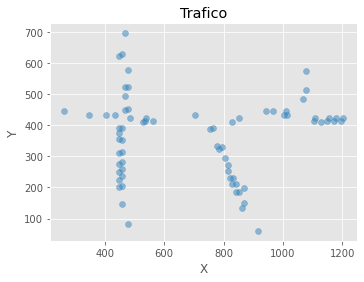

In [5]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5, 4))
ax.scatter(fx, fy, color="#3182bd", alpha=0.5)
ax.set_title('Trafico')
ax.set_xlabel('X')
ax.set_ylabel('Y');

In [6]:
data = {'X': fx, 'Y': fy}
datos = pd.DataFrame(data)
datos

,X,Y
0,263,445
1,345,434
2,403,433
3,433,435
4,447,377
...,...,...
68,1155,423
69,1173,413
70,1179,423
71,1195,413


In [7]:
# Validación cruzada para identificar kernel y bandwidth
# ==============================================================================

param_grid = {'kernel': ['gaussian', 'linear'],
              'bandwidth' : np.linspace(0.01, 3, 10)
             }

grid = GridSearchCV(
        estimator  = KernelDensity(),
        param_grid = param_grid,
        n_jobs     = -1, 
        cv         = LeaveOneOut(), 
        verbose    = 0
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = datos)

E:\Users\estudiante\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-4.07718867e+06            -inf -3.48527722e+03            -inf
 -9.01639561e+02            -inf -4.08445377e+02            -inf
 -2.34120361e+02            -inf -1.53117868e+02            -inf
 -1.09069536e+02            -inf -8.25273841e+01            -inf
 -6.53330915e+01            -inf -5.35783952e+01            -inf]
  warnings.warn(
E:\Users\estudiante\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


In [8]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_kde = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'bandwidth': 3.0, 'kernel': 'gaussian'} : -53.57839516671299 None


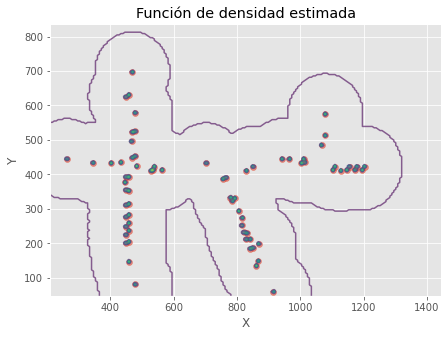

In [9]:
# Mapa de densidad de probabilidad
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

# Grid de valores dentro del rango observado (2 dimensiones)
x = np.linspace(min(datos.X)*0.8, max(datos.X)*1.2, 200)
y = np.linspace(min(datos.Y)*0.8, max(datos.Y)*1.2, 200)
xx, yy = np.meshgrid(x, y)
grid = np.column_stack((xx.flatten(), yy.flatten()))

# Densidad de probabilidad de cada valor del grid
log_densidad_pred = modelo_kde.score_samples(grid)
densidad_pred = np.exp(log_densidad_pred)

ax.scatter(fx, fy, alpha=0.6)
ax.contour(
    xx, yy, densidad_pred.reshape(xx.shape),
    alpha =0.6
)
ax.set_title('Función de densidad estimada')
ax.set_xlabel('X')
ax.set_ylabel('Y');

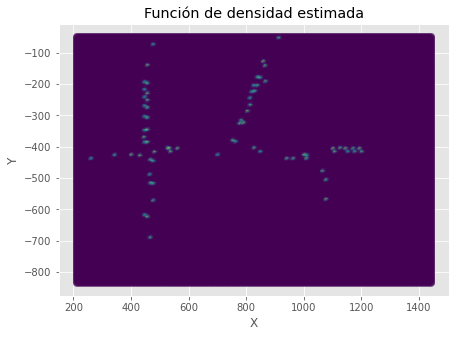

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
ax.scatter(grid[:,0], -grid[:,1], alpha=0.6, c=densidad_pred)
ax.set_title('Función de densidad estimada')
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.savefig('E:/Proyecto/Anaconda/trafico/densidad.png')

In [3]:
def generate_label(label_info, image_shape: List[int]):
    """
    Generate a density map based on objects positions.
    Args:
        label_info: (x, y) objects positions
        image_shape: (width, height) of a density map to be generated
    Returns:
        A density map.
    """
    # create an empty density map
    label = np.zeros(image_shape, dtype=np.float32)

    # loop over objects positions and marked them with 100 on a label
    for i in label_info:
        label[round(label_info[i][1])][round(label_info[i][0])] = 100

    # apply a convolution with a Gaussian kernel
    label = gaussian_filter(label, sigma=(1, 1), order=0)

    return label

In [4]:
def create_hdf5(dataset_name: str,
                train_size: int,
                valid_size: int,
                img_size: Tuple[int, int],
                in_channels: int=3):
    """
    Create empty training and validation HDF5 files with placeholders
    for images and labels (density maps).
    Note:
    Datasets are saved in [dataset_name]/train.h5 and [dataset_name]/valid.h5.
    Existing files will be overwritten.
    Args:
        dataset_name: used to create a folder for train.h5 and valid.h5
        train_size: no. of training samples
        valid_size: no. of validation samples
        img_size: (width, height) of a single image / density map
        in_channels: no. of channels of an input image
    Returns:
        A tuple of pointers to training and validation HDF5 files.
    """
    # create output folder if it does not exist
    os.makedirs(dataset_name, exist_ok=True)

    # create HDF5 files: [dataset_name]/(train | valid).h5
    train_h5 = h5py.File(os.path.join(dataset_name, 'train.h5'), 'w')
    valid_h5 = h5py.File(os.path.join(dataset_name, 'valid.h5'), 'w')

    # add two HDF5 datasets (images and labels) for each HDF5 file
    for h5, size in ((train_h5, train_size), (valid_h5, valid_size)):
        h5.create_dataset('images', (size, 3,img_size[0], img_size[1], 3))
        h5.create_dataset('labels', (size, 1,img_size[0], img_size[1]))

    return train_h5, valid_h5

In [5]:
def generate_data():
    """Generate HDF5 files for mall dataset."""
    # create training and validation HDF5 files
    train_h5, valid_h5 = create_hdf5('trafico',
                                     train_size=80,#17793,
                                     valid_size=20,#4453,
                                     img_size=(720, 1280),
                                     in_channels=3)

    def fill_h5(h5, inicial, final):
        """
        Save images and labels in given HDF5 file.
        Args:
            h5: HDF5 file
            inicial: id inicial
            final: id final
        """
        for i in range(inicial, final):
            img_path = "Imagenes/escena_" + str(i) + '.png'
            # get an image as numpy array
            image = Image.open(img_path)
            # generate a density map by applying a Gaussian filter
            label = generate_label(centros[str(i)], (720,1280))

            # save data to HDF5 file
            h5['images'][final-inicial-1, 0] = image
            h5['labels'][final-inicial-1, 0] = label
            if (i == final): break
     
    fill_h5(train_h5, 0, 80)#17794)
    fill_h5(valid_h5, 80, 99)#22247)

    # close HDF5 files
    train_h5.close()
    valid_h5.close()

In [6]:
generate_data()